In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# plt.rcParams['text.usetex'] = True

In [26]:
cat_tag = 'L750_n2e-4_z057_patchy_As2x'
data_dir = '/scratch/aew492/CFE_gradients_output'

### plot slices of mock catalogs

In [27]:
# weak ('more realistic') gradient mock
m1 = 0.1
mock1_dict = np.load(os.path.join(data_dir, f'gradient/1D/mock_data/{cat_tag}/{cat_tag}_rlz0_m-{m1:.3f}-L_b-0.500.npy'), allow_pickle=True).item()
mock1_data = mock1_dict['grad_set']
mock1_w_hat = mock1_dict['w_hat']
mock1_boxsize = mock1_dict['boxsize']

In [28]:
# strong gradient mock, where we can visually see the change in clustering
m2 = 1
mock2_dict = np.load(os.path.join(data_dir, f'gradient/2D/mock_data/{cat_tag}/{cat_tag}_rlz0_m-{m2:.3f}-L_b-0.500.npy'), allow_pickle=True).item()
mock2_data = mock2_dict['grad_set']
mock2_w_hat = mock2_dict['w_hat']
mock2_boxsize = mock2_dict['boxsize']


In [29]:
# super strong gradient mock
m3 = 20
mock3_dict = np.load(os.path.join(data_dir, f'gradient/2D/mock_data/{cat_tag}/{cat_tag}_rlz0_m-{m3:.3f}-L_b-0.500.npy'), allow_pickle=True).item()
mock3_data = mock3_dict['grad_set']
mock3_w_hat = mock3_dict['w_hat']
mock3_boxsize = mock3_dict['boxsize']

In [30]:
# no gradient gradient mock
m4 = 0
mock4_dict = np.load(os.path.join(data_dir, f'gradient/1D/mock_data/{cat_tag}/{cat_tag}_rlz2_m-{m4:.3f}-L_b-0.500.npy'), allow_pickle=True).item()
mock4_data = mock4_dict['grad_set']
mock4_w_hat = mock4_dict['w_hat']
mock4_boxsize = mock4_dict['boxsize']


In [31]:
# other two plots ?? maybe a totally clustered and totally unclustered ??
lognormo_set = mock3_dict['lognorm_set'].T
rand_set = mock3_dict['rand_set'].T

In [32]:
mock_data = [mock1_data, mock2_data, mock3_data, mock4_data]
gradients = [m1*mock1_w_hat, m2*mock2_w_hat, m3*mock3_w_hat, m4*mock4_w_hat]

In [33]:
# xy-slice for plotting
z_max = -200
data_slices = []
for data_set in mock_data:
    data_slices.append(data_set[np.where(data_set[:,2] < z_max)])

In [34]:
# plotting w_hat
def arrow(gradient):
    cent = [0,0]
    base = cent-gradient[:2]/2
    head = cent+gradient[:2]/2
    return base, head

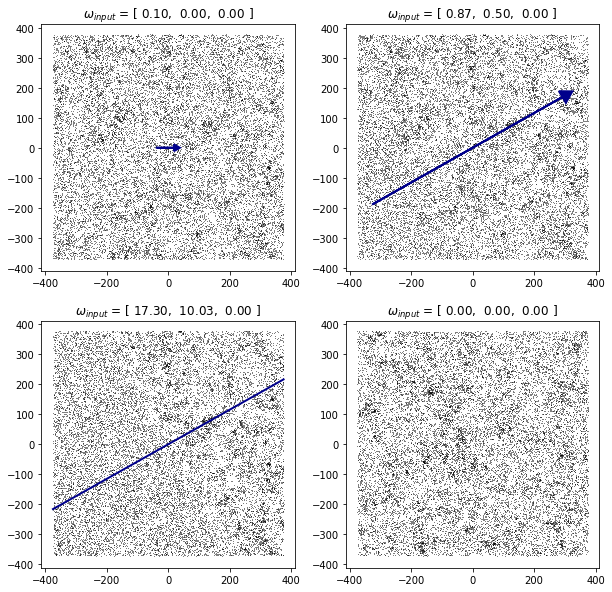

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

# plot galaxies
i = 0

L = mock1_boxsize
color='darkblue'
lw=2
As = [1,0.2,0.2,1]

for row in range(2):
    for col in range(2):
        ax = axs[row,col]
        data = data_slices[i]
        ax.plot(data[:,0], data[:,1], 'k,', alpha=0.5)
        ax.set_title(r'$\omega_{input}$'+' = [ {:.2f},  {:.2f},  {:.2f} ]'.format(gradients[i][0], gradients[i][1], gradients[i][2]))
        
        # plot w_hat arrow
        if i == 2:
            x = np.linspace(-L/2,L/2,2)
            ax.plot(x,(1/np.sqrt(3))*x,color=color, lw=lw, zorder=100)
            
        else:
            base, head = arrow(gradients[i])
            b = np.linalg.norm(head-base)
            ax.arrow(L*base[0], L*base[1], 2*L*head[0], 2*L*head[1], color=color, lw=lw,
                     head_width=0.3*As[i]*L*b, head_length=0.25*As[i]*L*b, length_includes_head=True, zorder=100)

        i += 1


In [ ]:
# check out lognormal files because something is weird
lognorm_sets = []
for i in range(10):
    mock_dict = np.load(os.path.join(data_dir, f'gradient/1D/mock_data/{cat_tag}/{cat_tag}_rlz{i}_m-1.000-L_b-0.500.npy'), allow_pickle=True).item()
    lognorm_set = mock_dict['lognorm_set']
    print(lognorm_set.shape)
    assert False
    lognorm_sets.append(lognorm_set)
    
    if i==0:
        print(mock_dict.keys())
    
    plt.plot(lognorm_set, 'k,')
